In [1]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from os import path,listdir
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [27]:
CURRENT_DIR = path.abspath(path.curdir)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Linear(4,16)
        self.layer2 = nn.Linear(16,32)
        self.layer3 = nn.Linear(32,16)
        self.layer4 = nn.Linear(16,2)


    def forward(self,x):
        
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        
        return x 

In [4]:
class Agent():
    def __init__(self,device,minmem,maxmem):
        self.env = gym.make("CartPole-v1")
        self.device = device
        self.net = Net().to(self.device)
        self.target = Net().to(self.device)
        self.target.load_state_dict(self.net.state_dict())
        self.maxmem = maxmem
        self.minmem = minmem
        self.memory = deque([], maxlen=self.maxmem)
        self.epsilon = 1
        self.decay = 0.995
        self.gamma = 0.95
        self.optim = torch.optim.Adam(self.net.parameters(),lr=0.01)
        self.scores = []
        self.means = []
        self.losses = []
        
    def predict(self,observation):
        return self.net(observation)
    
    
    def train(self,epochs,num_games,batch_size):
        
        e = 0
        
        while e<epochs:

            self.scores = []
            
            
            
            for _ in range(num_games):

                done = False
                observation = self.env.reset()
                trainexamples = []
                session_score = 0

                while not done:

                    nnet_input = torch.tensor(observation).float()

                    with torch.no_grad():

                        prediction = self.predict(nnet_input.to(self.device)).cpu()


                    if np.random.uniform(0,1)>self.epsilon:
                        action = 1 if prediction[1]>=prediction[0] else 0
                    else:
                        action = np.random.randint(0,2)

                    session_score += 1

                    observation, reward, done, info = self.env.step(action)
                    
                    next_state = torch.tensor(observation).float()

                    
                    trainexamples.append([nnet_input,action,-100 if done and session_score<500 else 1,next_state])

                current_reward = 0
                for example in reversed(trainexamples):
                    current_reward = example[2] + self.gamma*current_reward
                    self.memory.append([example[0][0],example[0][1],example[0][2],example[0][3],torch.tensor(example[1]),torch.tensor(current_reward)])

#                 for example in reversed(trainexamples):

#                     self.memory.append([example[0][0],example[0][1],example[0][2],example[0][3],torch.tensor(example[1]),torch.tensor(example[2]),example[3][0],example[3][1],example[3][2],example[3][3]])
 

                self.scores.append(session_score)
        
            
            
            
            mean = np.mean(self.scores[-num_games:])
            print(f'Epoch {e+1} mean score was {mean} over {len(self.scores)} games.')
            self.means.append(np.mean(self.scores))
            torch.save(self.net.state_dict(),f'./models/versions/dqn_{e}')
           
 
            self.epsilon = max(0.05,self.decay*self.epsilon)
    
            if len(self.memory)>self.minmem:

                for _ in range(5):
                
                    self.optim.zero_grad()

                    data = torch.tensor(random.sample(self.memory,batch_size))
                    nnet_input = data[:,:4]
                    actions = data[:,4]
                    rewards = data[:,5]
#                     next_states = data[:,6:]
                    

                    outputs = self.predict(nnet_input.to(self.device)).cpu()
 

#                     with torch.no_grad():
#                         maxqs = torch.max(self.target(next_states.to(self.device)).cpu(),axis=1)[0]
            


                    targets = outputs.clone()

                    for i in range(targets.shape[0]):
                        targets[i,actions[i].numpy()] = rewards[i] #+ self.gamma*maxqs[i]

                    loss = torch.mean((outputs-targets)**2)
                    self.losses.append(loss.item())
                    loss.backward()
                    self.optim.step()
                    

                
            e += 1
            
            
#             thetas = []
#             omegas = []
#             choices = []

#             for i in np.arange(-1,1,0.01):
#                 for j in np.arange(-10,10,0.1):
#                     nnet_input = torch.tensor((0,0,i,j))
#                     with torch.no_grad():
#                         output = self.net(nnet_input.cuda()).cpu()
#                     thetas.append(i)
#                     omegas.append(j)
#                     choices.append(np.argmax(output).item())
                    
#             arr1 = np.array(thetas)
#             arr2 = np.array(omegas)
#             arr3 = np.array(choices)
            
#             plt.scatter(arr1[np.where(arr3==0)],arr2[np.where(arr3==0)],c="blue")
#             plt.scatter(arr1[np.where(arr3==1)],arr2[np.where(arr3==1)],c="red")
#             plt.title("Neural Network Decision Boundary")
#             plt.xlim([-0.1,0.1])
#             plt.ylim([-1,1])
#             plt.xlabel("Pole Angle")
#             plt.ylabel("Pole Angular Velocity")
#             plt.savefig(f'Tracking Net/snapshot {e}.png')
#             plt.clf()
                    
                    
            if e+1%10==0:
                torch.save(self.net.state_dict(),'./models/dqn')
                self.target.load_state_dict(self.net.state_dict())  

#             print(f'Epoch {e} completed')

In [73]:
# torch.save(agent.net.state_dict(),'./models/random_dqn')

In [5]:
agent = Agent(DEVICE,minmem=10000,maxmem=100000)

In [6]:
agent.train(epochs=1000,num_games=100,batch_size=1024)

Epoch 1 mean score was 21.56 over 100 games.
Epoch 2 mean score was 23.36 over 100 games.
Epoch 3 mean score was 21.76 over 100 games.
Epoch 4 mean score was 23.63 over 100 games.
Epoch 5 mean score was 24.7 over 100 games.
Epoch 6 mean score was 22.03 over 100 games.
Epoch 7 mean score was 24.45 over 100 games.
Epoch 8 mean score was 22.65 over 100 games.
Epoch 9 mean score was 23.71 over 100 games.
Epoch 10 mean score was 20.97 over 100 games.
Epoch 11 mean score was 22.64 over 100 games.
Epoch 12 mean score was 20.89 over 100 games.
Epoch 13 mean score was 23.04 over 100 games.
Epoch 14 mean score was 21.16 over 100 games.
Epoch 15 mean score was 22.11 over 100 games.
Epoch 16 mean score was 21.33 over 100 games.
Epoch 17 mean score was 21.64 over 100 games.
Epoch 18 mean score was 21.96 over 100 games.
Epoch 19 mean score was 22.34 over 100 games.
Epoch 20 mean score was 20.93 over 100 games.
Epoch 21 mean score was 23.16 over 100 games.
Epoch 22 mean score was 22.55 over 100 games

Epoch 177 mean score was 219.22 over 100 games.
Epoch 178 mean score was 215.78 over 100 games.
Epoch 179 mean score was 229.82 over 100 games.
Epoch 180 mean score was 238.22 over 100 games.
Epoch 181 mean score was 229.79 over 100 games.
Epoch 182 mean score was 229.08 over 100 games.
Epoch 183 mean score was 237.72 over 100 games.
Epoch 184 mean score was 276.48 over 100 games.
Epoch 185 mean score was 274.21 over 100 games.
Epoch 186 mean score was 253.46 over 100 games.
Epoch 187 mean score was 228.87 over 100 games.
Epoch 188 mean score was 276.57 over 100 games.
Epoch 189 mean score was 222.97 over 100 games.
Epoch 190 mean score was 208.51 over 100 games.
Epoch 191 mean score was 261.69 over 100 games.
Epoch 192 mean score was 187.25 over 100 games.
Epoch 193 mean score was 269.17 over 100 games.
Epoch 194 mean score was 283.0 over 100 games.
Epoch 195 mean score was 306.21 over 100 games.
Epoch 196 mean score was 305.88 over 100 games.
Epoch 197 mean score was 222.63 over 100 

Epoch 349 mean score was 497.74 over 100 games.
Epoch 350 mean score was 497.05 over 100 games.
Epoch 351 mean score was 497.57 over 100 games.
Epoch 352 mean score was 495.83 over 100 games.
Epoch 353 mean score was 500.0 over 100 games.
Epoch 354 mean score was 499.1 over 100 games.
Epoch 355 mean score was 493.1 over 100 games.
Epoch 356 mean score was 500.0 over 100 games.
Epoch 357 mean score was 500.0 over 100 games.
Epoch 358 mean score was 500.0 over 100 games.
Epoch 359 mean score was 500.0 over 100 games.
Epoch 360 mean score was 500.0 over 100 games.
Epoch 361 mean score was 495.21 over 100 games.
Epoch 362 mean score was 499.77 over 100 games.
Epoch 363 mean score was 499.42 over 100 games.
Epoch 364 mean score was 497.72 over 100 games.
Epoch 365 mean score was 500.0 over 100 games.
Epoch 366 mean score was 500.0 over 100 games.
Epoch 367 mean score was 500.0 over 100 games.
Epoch 368 mean score was 500.0 over 100 games.
Epoch 369 mean score was 500.0 over 100 games.
Epoch

Epoch 522 mean score was 92.93 over 100 games.
Epoch 523 mean score was 81.42 over 100 games.
Epoch 524 mean score was 107.22 over 100 games.
Epoch 525 mean score was 160.17 over 100 games.
Epoch 526 mean score was 228.4 over 100 games.
Epoch 527 mean score was 374.44 over 100 games.
Epoch 528 mean score was 278.95 over 100 games.
Epoch 529 mean score was 166.08 over 100 games.
Epoch 530 mean score was 126.16 over 100 games.
Epoch 531 mean score was 169.82 over 100 games.
Epoch 532 mean score was 284.32 over 100 games.
Epoch 533 mean score was 198.32 over 100 games.
Epoch 534 mean score was 291.98 over 100 games.
Epoch 535 mean score was 123.18 over 100 games.
Epoch 536 mean score was 33.34 over 100 games.
Epoch 537 mean score was 55.23 over 100 games.
Epoch 538 mean score was 270.76 over 100 games.
Epoch 539 mean score was 179.56 over 100 games.
Epoch 540 mean score was 140.3 over 100 games.
Epoch 541 mean score was 127.12 over 100 games.
Epoch 542 mean score was 119.83 over 100 games

Epoch 694 mean score was 112.82 over 100 games.
Epoch 695 mean score was 112.99 over 100 games.
Epoch 696 mean score was 114.58 over 100 games.
Epoch 697 mean score was 115.57 over 100 games.
Epoch 698 mean score was 113.42 over 100 games.
Epoch 699 mean score was 113.57 over 100 games.
Epoch 700 mean score was 110.94 over 100 games.
Epoch 701 mean score was 112.65 over 100 games.
Epoch 702 mean score was 113.94 over 100 games.
Epoch 703 mean score was 113.68 over 100 games.
Epoch 704 mean score was 113.48 over 100 games.
Epoch 705 mean score was 113.01 over 100 games.
Epoch 706 mean score was 114.25 over 100 games.
Epoch 707 mean score was 112.2 over 100 games.
Epoch 708 mean score was 116.17 over 100 games.
Epoch 709 mean score was 116.87 over 100 games.
Epoch 710 mean score was 115.26 over 100 games.
Epoch 711 mean score was 114.23 over 100 games.
Epoch 712 mean score was 115.11 over 100 games.
Epoch 713 mean score was 115.65 over 100 games.
Epoch 714 mean score was 117.39 over 100 

Epoch 865 mean score was 142.55 over 100 games.
Epoch 866 mean score was 133.66 over 100 games.
Epoch 867 mean score was 135.57 over 100 games.
Epoch 868 mean score was 140.79 over 100 games.
Epoch 869 mean score was 138.79 over 100 games.
Epoch 870 mean score was 134.69 over 100 games.
Epoch 871 mean score was 143.24 over 100 games.
Epoch 872 mean score was 154.35 over 100 games.
Epoch 873 mean score was 141.97 over 100 games.
Epoch 874 mean score was 136.28 over 100 games.
Epoch 875 mean score was 144.66 over 100 games.
Epoch 876 mean score was 149.7 over 100 games.
Epoch 877 mean score was 145.94 over 100 games.
Epoch 878 mean score was 145.29 over 100 games.
Epoch 879 mean score was 150.05 over 100 games.
Epoch 880 mean score was 150.24 over 100 games.
Epoch 881 mean score was 148.53 over 100 games.
Epoch 882 mean score was 148.84 over 100 games.
Epoch 883 mean score was 152.11 over 100 games.
Epoch 884 mean score was 154.43 over 100 games.
Epoch 885 mean score was 153.28 over 100 

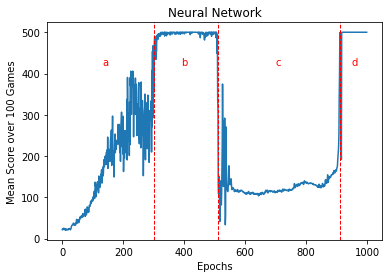

In [25]:
plt.plot(agent.means)

plt.title("Neural Network")
plt.xlabel("Epochs")
plt.ylabel("Mean Score over 100 Games")

plt.axvline(300,color="r",linestyle= "--",lw=1)
plt.axvline(511,color="r",linestyle="--",lw=1)
plt.axvline(910,color="r",linestyle="--",lw=1)

plt.text(130,420,"a",c="r")
plt.text(390,420,"b",c="r")
plt.text(700,420,"c",c="r")
plt.text(950,420,"d",c="r")

plt.savefig("graphics/NeuralNetworkTrain.png")
plt.show();

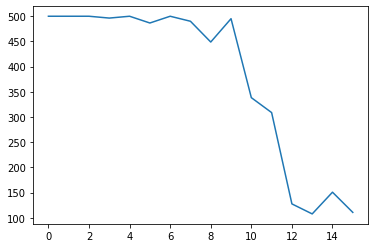

In [97]:
plt.plot(agent.means[500:516])

In [104]:
observation = env.reset()
frames = []
locations = []

version = 999

testagent = Agent(DEVICE,minmem=10000,maxmem=100000)
testagent.net.load_state_dict(torch.load(f'models/Versions/dqn_{version}'))

for t in range(1000):
    #Render to frames buffer
    frames.append(env.render(mode="rgb_array"))
    locations.append(observation[2:])
    with torch.no_grad():
        nnet_input = torch.tensor(observation).float()
        action = np.argmax(testagent.predict(nnet_input.to(testagent.device)).cpu().numpy())

    observation, _, done, _ = env.step(action)
    if done:
        break
env.close()
print("")
print(len(frames))


500


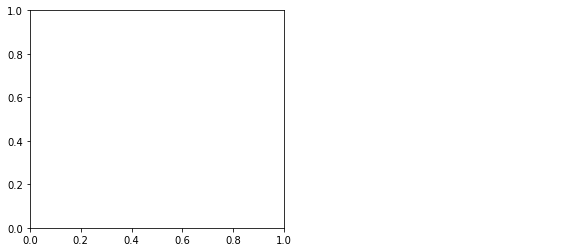

In [105]:
x,y = np.meshgrid(np.linspace(-0.2,0.2,20),np.linspace(-1.5,1.5,20))

speedx = x.copy()

for i in range(20):
    for j in range(20):
        
        speedx[i,j] = math.sin(speedx[i,j])

u = y
v = speedx

model = "Neural Network"

f,axi = plt.subplots(1,2,figsize=(10,4))
axi[1].axis("off")

for i,frame in enumerate(frames):

    axi[0].quiver(x,y,u,v)
    axi[0].scatter(locations[i][0],locations[i][1],s=50,c='r')
    axi[0].set_title("Phase Space Diagram")
    axi[0].set_xlabel("Pole Angle")
    axi[0].set_ylabel("Pole Angular Velocity")
    axi[0].set_xlim([-0.2,0.2])
    axi[0].set_ylim([-1.5,1.5])

    axi[1].imshow(frame)
    axi[1].set_title(model)
    axi[1].text(400,100,f'Score = {i+1}',size=20)


    f.savefig(f'pieces/{model} {i}.png')
    
    axi[0].cla()
    axi[1].cla()
    axi[1].axis("off");

In [106]:
images = [Image.open(f'pieces/{model} {i}.png') for i in range(len(listdir("pieces")))]

im = Image.new('RGB', (720,288))
im.save('graphics/neural_network_model_d.gif', save_all=True, append_images=images,loop=0)

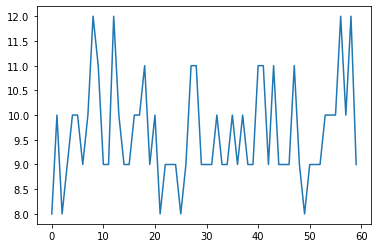

In [148]:
plt.plot(agent.scores);

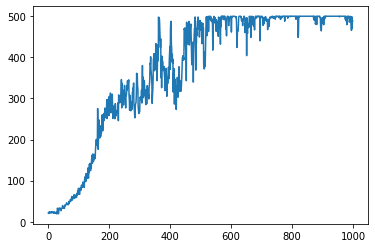

In [8]:
plt.plot(agent.means);

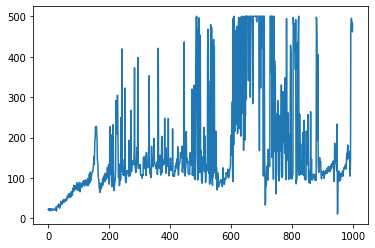

In [15]:
plt.plot(agent.means);

In [196]:
agent.epsilon

0.35608578229633

In [16]:
env = gym.make("CartPole-v1")

In [24]:
observation = env.reset()
nnet_input = torch.tensor(observation).float()
print(nnet_input)
with torch.no_grad():
    prediction = agent.predict(nnet_input.to(DEVICE)).cpu()
print(prediction)

tensor([ 0.0162, -0.0468,  0.0376,  0.0083])
tensor([-85.4893, -85.3934])


In [60]:

# for _ in range(50):
if True:
    observation = env.reset()
    done = False

    i = 0
    while not done:

#         env.render()
        nnet_input = torch.tensor(observation).float()

        with torch.no_grad():

            prediction = agent.predict(nnet_input.to(DEVICE)).cpu()

        print(observation)
        print(prediction)
        print('')

        action = np.argmax(prediction).item()

        observation, reward, done, info = env.step(action)

        i += 1

#     print(i)


[-0.01325967  0.00823835  0.01401963  0.01479182]
tensor([0.6590, 0.3380])

[-0.0130949  -0.18708182  0.01431546  0.31186493]
tensor([0.6577, 0.3413])

[-0.01683654 -0.38240476  0.02055276  0.60902792]
tensor([0.6565, 0.3443])

[-0.02448463 -0.57780791  0.03273332  0.90811282]
tensor([0.6555, 0.3469])

[-0.03604079 -0.77335732  0.05089558  1.21090168]
tensor([0.6551, 0.3420])

[-0.05150794 -0.96909808  0.07511361  1.51908947]
tensor([0.6551, 0.3362])

[-0.0708899  -1.16504353  0.1054954   1.83424153]
tensor([0.6551, 0.3362])

[-0.09419077 -1.36116249  0.14218023  2.15774264]
tensor([ 0.6067, -2.3603])

[-0.12141402 -1.55736423  0.18533508  2.49073585]
tensor([-100.4042, -100.8642])



In [9]:
means_random = pd.DataFrame({"means":agent.means})
means_random.to_csv(CURRENT_DIR + "/Results/means_randomnet.csv")

In [107]:
means_net = pd.DataFrame({"means":agent.means})
means_net.to_csv(CURRENT_DIR + "/Results/means_net.csv")

In [23]:
df.head()

,means
0,21.14
1,21.26
2,21.81
3,21.89
4,21.11


In [75]:
svmdf = pd.read_csv(CURRENT_DIR + "/Results/means_svm.csv")
randf = pd.read_csv(CURRENT_DIR + "/Results/means_randomnet.csv")
netdf = pd.read_csv(CURRENT_DIR + "/Results/means_net.csv")

In [39]:
means_random.to_csv(CURRENT_DIR + "/Results/means_randomnet.csv")

In [14]:
svmdf["0"].values

array([ 21,  14,  14, ..., 500, 500, 373], dtype=int64)

In [20]:
netdf

,Unnamed: 0,means
0,0,21.14
1,1,21.26
2,2,21.81
3,3,21.89
4,4,21.11
...,...,...
551,551,500.00
552,552,500.00
553,553,500.00
554,554,500.00


In [17]:
len(svmdf["0"].values)

1056181

In [18]:
scores = []
for i in range(len(svmdf["0"].values)):
    
    scores.append(np.mean(svmdf["0"].values[i*100:i*100+100]))

P:\Users\Owner\Anaconda3\envs\bigbrain\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
P:\Users\Owner\Anaconda3\envs\bigbrain\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


''

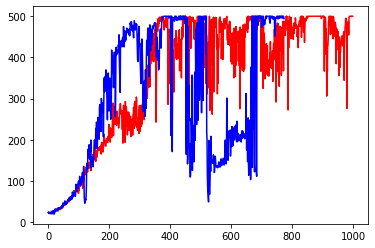

In [76]:
plt.plot(randf["means"].values,"red")
plt.plot(netdf["means"].values,"blue")
# plt.plot(svmdf["means"].values,"green")
;

In [24]:
df = pd.DataFrame({"means":scores})
df.to_csv(CURRENT_DIR + "/Results/means_svm.csv")

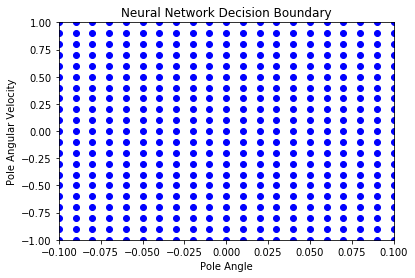

In [149]:
thetas = []
omegas = []
choices = []

for i in np.arange(-0.1,0.1,0.0005):
    for j in np.arange(-1,1,0.005):
        nnet_input = torch.tensor((0,0,i,j))
        with torch.no_grad():
            output = agent.net(nnet_input.cuda()).cpu()
        thetas.append(i)
        omegas.append(j)
        choices.append(np.argmax(output).item())

arr1 = np.array(thetas)
arr2 = np.array(omegas)
arr3 = np.array(choices)

plt.scatter(arr1[np.where(arr3==0)],arr2[np.where(arr3==0)],c="blue")
plt.scatter(arr1[np.where(arr3==1)],arr2[np.where(arr3==1)],c="red")
plt.title("Neural Network Decision Boundary")
plt.xlim([-0.1,0.1])
plt.ylim([-1,1])
plt.xlabel("Pole Angle")
plt.ylabel("Pole Angular Velocity")
plt.savefig(f'Tracking Net/snapshot 0.png')

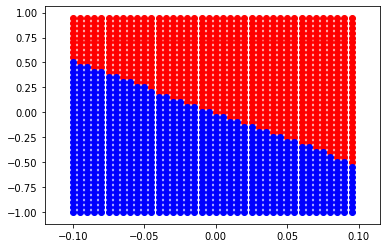

In [119]:
plt.scatter(test0[np.where(test2==1)],test1[np.where(test2==1)],c="red")
plt.scatter(test0[np.where(test2==0)],test1[np.where(test2==0)],c="blue");

In [100]:
test0 = np.array(thetas)
test1 = np.array(omegas)
test2 = np.array(choices)

In [103]:
len(test0[np.where(test2==1)])

776

In [104]:
len(test0)

1600

In [111]:
thetas[np.where(test2==1)[0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [113]:
np.where(test2==1)[0]

array([  31,   32,   33,   34,   35,   36,   37,   38,   39,   70,   71,
         72,   73,   74,   75,   76,   77,   78,   79,  110,  111,  112,
        113,  114,  115,  116,  117,  118,  119,  149,  150,  151,  152,
        153,  154,  155,  156,  157,  158,  159,  189,  190,  191,  192,
        193,  194,  195,  196,  197,  198,  199,  228,  229,  230,  231,
        232,  233,  234,  235,  236,  237,  238,  239,  268,  269,  270,
        271,  272,  273,  274,  275,  276,  277,  278,  279,  307,  308,
        309,  310,  311,  312,  313,  314,  315,  316,  317,  318,  319,
        347,  348,  349,  350,  351,  352,  353,  354,  355,  356,  357,
        358,  359,  386,  387,  388,  389,  390,  391,  392,  393,  394,
        395,  396,  397,  398,  399,  426,  427,  428,  429,  430,  431,
        432,  433,  434,  435,  436,  437,  438,  439,  465,  466,  467,
        468,  469,  470,  471,  472,  473,  474,  475,  476,  477,  478,
        479,  504,  505,  506,  507,  508,  509,  5

In [ ]:
observation = env.reset()
frames = []
locations = []
for t in range(1000):
    #Render to frames buffer
    frames.append(env.render(mode="rgb_array"))
    locations.append(observation[2:])
    action = model.predict(np.asarray(observation[2:]).reshape(-1,2))[0]
    observation, _, done, _ = env.step(action)
    if done:
        break
env.close()
# save_frames_as_gif(frames)
print(len(frames))

In [139]:
test = pd.read_csv(CURRENT_DIR + "/Results/means2.csv")
print(len(test["0"].iloc[::10]))
print(len(test["0"]))

105609
1056082


In [151]:
values = test["0"].iloc[::10]
print(len(values.values))

105609


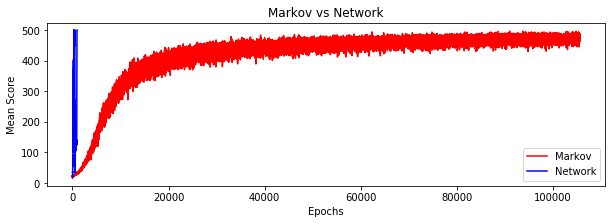

In [152]:
plt.figure(figsize=(10,3))
plt.plot(values.values,"r",label="Markov")
plt.plot(agent.means,"b",label="Network")
plt.legend(loc="lower right")
plt.title("Markov vs Network")
plt.xlabel("Epochs")
plt.ylabel("Mean Score")

plt.savefig("graphics/markovvsnetwork.png")
plt.show();

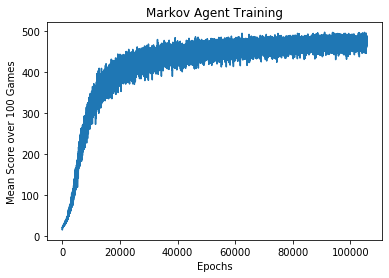

In [156]:
plt.plot(values.values)
plt.title("Markov Agent Training")
plt.xlabel("Epochs")
plt.ylabel("Mean Score over 100 Games")
plt.savefig("graphics/markovagenttraining.png")

plt.show();